<h1><center>  Project - Advanced Statistics in ML - Spring 2019 </center></h1>
 
 
 
 <h1><center>  Non Linear Dimensionality Reduction </center></h1>
 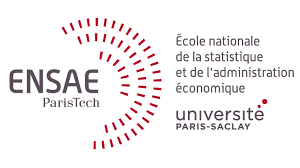
 <h3>  <p style="text-align:left;">Authors: <span style="float:right;"> Professor:<br>
     <br> Stéphan Clémençon
 </span></p>
 
 Clémentine Rosier <br> Alexandre Filiot



# Outline
 
## <a href="#Abstract" style="color:#00925B">1.&nbsp;&nbsp;Abstract</a>


## <a href="#Methods implementation" style="color:#00925B">2.&nbsp;&nbsp;Methods implementation</a>

> <a href="#Basic functions" style="color:#00925B">2.1.&nbsp;&nbsp;Basic functions</a>
>
> <a href="#Metric MultiDimensional Scaling" style="color:#00925B">2.2.&nbsp;&nbsp;Metric MultiDimensional Scaling</a>
>
> <a href="#Kernel PCA" style="color:#00925B">2.3.&nbsp;&nbsp;Kernel PCA</a>
>
> <a href="#Laplacian EigenMaps" style="color:#00925B">2.4.&nbsp;&nbsp;Laplacian EigenMaps</a>
>
> <a href="#Locally Linear Embedding" style="color:#00925B">2.5.&nbsp;&nbsp;Locally Linear Embedding</a>

## <a href="#Tests on synthetic data" style="color:#00925B">3.&nbsp;&nbsp;Tests on synthetic data</a>

> <a href="#Spheres" style="color:#00925B">3.1.&nbsp;&nbsp;Spheres</a>
>
>> <a href="#Full comparison" style="color:#00925B">3.1.1 &nbsp;&nbsp;Full comparison</a>
>>
>> <a href="#Kernel PCA: influence of sigma" style="color:#00925B">3.1.1 &nbsp;&nbsp;Kernel PCA: influence of sigma</a>


<a id='Abstract'></a>

# Abstract

The following notebook provides our work as part of the evaluation of "Advanced Statistics in ML" course. Our project is dedicated to Non Linear Dimensionality Reduction (hereinafter, NLDR). Despite that each of the studied methods are fully and optimally implemented in the Scikit-Learn library, we have coded our own versions of some methods of interests: Principal Components Analysis (PCA), Kernal PCA, Metric Multidimensional Scaling (MDS), Locally Linear Embedding (LLE) and Laplacian EigenMaps (LEM). The references can be found in the report (on the master branch). 

The notebook is divided into 3 main parts: 
- Methods implementation;
- Test on synthetic data; 
- Test on the MNIST data set.

We fully provide the elements of analysis and comparison in the report. 

In [1]:
# Basic packages
import numpy as np
from numpy import random, cos, sin, sqrt, pi
import pandas as pd
from tqdm import tqdm
from time import time

# Optimisation
from numpy.linalg import multi_dot
from scipy.linalg import eig, eigh, solve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse.csgraph import connected_components

# Load and dump files
import zipfile, os, pickle

# Graphics
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.ticker import NullFormatter

# Sklearn functions
import sklearn.metrics.pairwise as skp            # to compute kernels in KPCA
from sklearn.neighbors import NearestNeighbors    # to compute nearest neighbors
from sklearn import manifold, datasets            # to load Sklearn NLDR methods and benchmark datasets

# Other
import inspect

<a id='Methods implementation'></a>

# Methods implementation

<a id='Basic functions'></a>

## Basic functions

In [131]:
def centering(K):
    """
    Center kernel
    :param K: np.array
    :return: np.array
    """
    n = K.shape[0]
    B = np.eye(n) - np.ones((n, n))/n
    return multi_dot([B, K, B])

def gaussian(X, sigma):
    """
    Compute Gaussian kernel with noise parameter sigma 
    :param X: np.array
    :param sigma: float
    :return: np.array
    """
    return skp.rbf_kernel(X, gamma=sigma)

def polynomial(X, d):
    """
    Compute Linear kernel with degree d: K(x,y)=(xy)^d
    :param X: np.array
    :param d: int
    :return: np.array
    """
    return skp.polynomial_kernel(X, degree=d)

def sigmoid(X, gamma):
    """
    Compute sigmoid kernel K(x,y)=(gamma*(tanh(x,y)+1))
    :param X: np.array
    :param gamma: float
    :return: np.array
    """
    return skp.sigmoid_kernel(X, gamma=gamma)

The different following functions are inspired from the classical scheme fit / transform / fit_transform which has become the norm in every ML and DL library.  `fit` aims at calibrating the model and compute the quantities of interest for applying the model on either the train set (hence `fit_transform`) or the test set (see `transform`). `X`and `y` always refer to `numpy.arrays`, this should not be changed (do not use `pandas.DataFrame` or `csr_matrix` for instance).

<a id='Metric MultiDimensional Scaling'></a>

## Metric MultiDimensional Scaling

In [136]:
class MDS():
    """
    Metric MultiDimensional Scaling
    """
    def __init__(self, p, verbose=False):
        """
        :param p: np.int, dimension of the embedded submanifold to learn
        """
        self.p = p
        self.verboseprint = print if verbose else lambda *a, **k: None
        
    def fit(self, X):
        """
        Compute the eigenvalues of X^T X and sort them in descreasing order
        """
        X_c = X-X.mean(axis=0)
        self.S = np.dot(X_c, X_c.T)
        vals, vecs = eigh(a=self.S)
        idx = vals.argsort()[::-1]
        self.eigVl = np.abs(vals[idx])
        self.eigVc = vecs[:, idx]
        
    def fit_transform(self, X, y):
        """
        Transform on train set: there is no available method for transforming on new data
        """
        self.fit(X)
        new_X = self.newData(X, y)
        new_X.iloc[:, :self.isy] = multi_dot((np.eye(self.p, X.shape[0]),
                                              np.sqrt(np.diag(self.eigVl)),
                                              self.eigVc.T)).T
        return new_X
    
    def newData(self, X, y):
        """
        Returns a pd.DataFrame with the new coordinates in the p dimensional subspace
        """
        n = X.shape[0]
        z = np.zeros(n)
        dict_ = dict(zip(['a'+str(i) for i in range(self.p)], [z]*self.p))
        if y is not None:
            dict_['Y'] = y
            self.isy = -1
        else:
            self.isy = self.p+1
        new_X = pd.DataFrame(dict_)
        return new_X

<a id='Kernel PCA'></a>

## Kernel PCA

In [155]:
class kernelPCA():
    """
    Kernel Principal Components Analysis
    """
    def __init__(self, method, params, p, verbose=False):
        """
        :param method: function, choose between polynomial, gaussian or sigmoid
        :param params: dict, for - Gaussian kernel   : {'sigma': x}
                                 - Polynomial kernel : {'d': x}
                                 - Sigmoid kernel    : {'gamma': x}
        :param p: int, dimension of the embedded submanifold to learn
        :param verbose: Bool, whether or not to display callbacks
        """
        self.method = method
        self.params = params
        self.p = p
        self.verboseprint = print if verbose else lambda *a, **k: None
        
    def fit(self, X_train):
        """
        Compute the normalized eigenvectors of the Gram matrix
        """
        self.X_train = X_train
        self.verboseprint('...Computing Gram matrix...')
        self.K = self.getK(X_train)
        self.verboseprint('...Computing eigenvectors...')
        eigVl, eigVc = self.getEigs(self.K)
        eigVc /= np.sqrt(eigVl)
        self.alpha = eigVc
        
    def fit_transform(self, X_train):
        """
        Transform on train set
        """
        self.fit(X_train)
        new_X = self.newData(X_train)
        self.verboseprint('...Projecting onto a{:3.0f}-dimensional space...'.format(self.p))
        for i in range(X_train.shape[0]):
            Ki = self.K[i]
            for k in range(self.p):
                new_X.iloc[i, k] = np.dot(Ki, self.alpha[:, k])
        return new_X
    
    def transform(self, X_test):
        """
        Transform on test set
        """
        new_X = self.newData(X_test)
        self.X_test = X_test
        self.verboseprint('...Projecting on test...')
        for i, x_test in enumerate(self.X_test[:, :-1]):
            v = []
            for j, x_train in enumerate(self.X_train[:, :-1]):
                v.append(self.phi(x_test, x_train))
            for k in range(self.p):
                new_X.iloc[i, k] = np.dot(np.array(v), self.alpha[:, k])
        return new_X
        
    def getEigs(self, K):
        """
        Eigenvalue decomposition
        :param K: np.array, kernel matrix
        :return: np.arrays, eigenvalues and corresponding eigenvectors
        """
        eigenValues, eigenVectors = eigh(K)
        idx = eigenValues.argsort()[::-1][:self.p]
        return eigenValues[idx], eigenVectors[:, idx]

    def getK(self, X):
        """
        Return the kernel matrix according to the input method
        """
        if self.method.__name__ == 'gaussian':
            sigma = self.params['sigma']
            K = centering(gaussian(X, sigma=0.5/sigma**2))
            self.phi = lambda x,y : np.exp(-0.5 * np.linalg.norm(x-y, ord=2)**2 / sigma**2)
        elif self.method.__name__ == 'polynomial':
            d = self.params['d']
            K = centering(polynomial(X, d=d))
            self.phi = lambda x,y : np.dot(x, y)**d
        elif self.method.__name__ == 'sigmoid':
            gamma = self.params['gamma']
            K = centering(sigmoid(X, gamma=gamma))
            self.phi = lambda x,y : np.tanh(gamma * np.dot(x, y))
        return K
    
    def newData(self, X):
        """
        Return a pd.DataFrame with the new coordinates in the p dimensional subspace
        """
        n = X.shape[0]
        z = np.zeros(n)
        dict_ = dict(zip(['a'+str(i) for i in range(self.p)], [z]*self.p))
        dict_['Y'] = X[:, -1]
        new_X = pd.DataFrame(dict_)
        return new_X

<a id='Laplacian EigenMaps'></a>

## Laplacian EigenMaps

In [139]:
class LEM():
    """
    Laplacian EigenMaps 
    """
    def __init__(self, k, p, reg, gamma, verbose=False):
        """
        :param k: int, number of nearest neighbors
        :param p: int, dimension of the embedded submanifold to learn
        :param reg: float, penalization parameter to make matrix G invertible (linear system: G * w_opt = (1,...,1), see get_weights)
        :param gamma: float, parameter t in the Belkin et al. (2003) characterizing the diffusion
        :param verbose: Bool, whether or not to display callbacks
        """
        self.k = k 
        self.p = p
        self.reg = reg
        self.gamma = gamma
        self.verboseprint = print if verbose else lambda *a, **k: None
        
    def fit(self, X):
        """
        Compute the p first eigenvectors and eigenvalues in increasing order excluding the null eigenvalue
        """
        self.X_train=X
        # For each data point, find its self.k nearest neighbors
        self.nbrs = NearestNeighbors(n_neighbors=self.k+1, algorithm='ball_tree').fit(X)
        self.neighbors = self.nbrs.kneighbors(X, n_neighbors=self.k+1, return_distance=False)[:, 1:]
        # Store the corresponding BINARY adjacency matrix
        graph = self.nbrs.kneighbors_graph(X).toarray()
        # Compute the number of connected components. /!\ If self.n_components > 1, the algorithm might not work perfectly
        self.graph = np.maximum(graph, graph.T)
        self.n_components, self.labels = connected_components(csgraph=csr_matrix(graph), directed=False, return_labels=True)
        self.verboseprint('Number of connected components: {:3.0f}'.format(self.n_components))
        # Weight matrix W using the diffusion kernel
        W = gaussian(X, sigma=0.25/self.gamma) * self.graph
        # Matrix D
        D = np.diag([np.sum(W[i]) for i in range(W.shape[0])])
        # Laplacian L
        L = D-W
        # Generalized eigenvalue problem
        vals, vecs = eigh(a=L, b=D) 
        idx = vals.argsort()[1:self.p+1]
        self.eigVl = vals[idx]
        self.eigVc = vecs[:, idx]
        
    def get_weigths(self, X):
        """
        Compute the weights that, for each data point, optimally (and linearly) reconstructs the latter. 
        The solution w_opt is given by solving the linear system G * w_opt = (1,...,1) where G is defined 
        in the report. /!\ This is only useful for transforming new data points /!\ and is not part of the 
        original method
        """
        Weights = np.empty((X.shape[0], self.k))
        v = np.ones(self.k, dtype=X.dtype)
        for i, x in enumerate(X):
            ind = self.neighbors[i]
            Nx = X[ind]
            G = np.dot((x-Nx), (x-Nx).T)
            trace = np.trace(G)
            if trace > 0:
                R = self.reg * trace
            else:
                R = self.reg
            G += R * np.eye(self.k)
            w = solve(G, v, sym_pos=True)
            Weights[i] = w / np.sum(w)
        return Weights

    def fit_transform(self, X, y):
        """
        Transform on train set
        """
        self.fit(X)
        self.Weights = self.get_weigths(X)
        new_X = self.newData(X, y)
        self.verboseprint('Projecting onto a{:3.0f}-dimensional space'.format(self.p))
        for i in range(X.shape[0]):
            ind = self.neighbors[i]
            eigs = self.eigVc[ind]
            w = self.Weights[i]
            new_X.iloc[i, :self.isy] = np.sum((w * eigs.T[:, None]).T, axis=0)
        self.verboseprint('Done.')
        return new_X
    
    
    def transform(self, X, y):
        """
        Transform on test set: - find the self.k nearest (training) neighbors of a new data point
                               - solve the linear system to find w_opt
                               - re-use the eigenvectors weighted by w_opt
        This method is inspired from LLE (see below)
        """
        v = np.ones(self.k, dtype=X.dtype)
        new_X = self.newData(X, y)
        neighbors_test = self.nbrs.kneighbors(X, n_neighbors=self.k, return_distance=False)
        for i, x in enumerate(X_test):
            ind = neighbors_test[i]
            eigs = self.eigVc[ind]
            Nx = self.X_train[ind]
            G = np.dot((x-Nx), (x-Nx).T)
            trace = np.trace(G)
            # Add a penalisation to make G invertible
            if trace > 0:
                R = self.reg * trace
            else:
                R = self.reg
            G += R * np.eye(self.k)
            w = solve(G, v, sym_pos=True)
            new_X.iloc[i, :self.isy] = np.sum(((w / np.sum(w)) * eigs.T[:, None]).T, axis=0)
        return new_X
    
    def newData(self, X, y):
        """
        Return a pd.DataFrame with the new coordinates in the p dimensional subspace
        """
        n = X.shape[0]
        z = np.zeros(n)
        dict_ = dict(zip(['a'+str(i) for i in range(self.p)], [z]*self.p))
        if y is not None:
            dict_['Y'] = y
            self.isy = -1
        else:
            self.isy = self.p+1
        new_X = pd.DataFrame(dict_)
        return new_X

<a id='Locally Linear Embedding'></a>

## Locally Linear Embedding

In [140]:
class LLE():
    """
    Locally Linear Embedding
    """
    def __init__(self, k, p, reg, verbose=False):
        """
        :param k: int, number of nearest neighbors
        :param p: int, dimension of the embedded submanifold to learn
        :param reg: float, penalization parameter to make matrix G invertible (linear system: G * w_opt = (1,...,1), see get_weights)
        :param verbose: Bool, whether or not to display callbacks
        """
        self.k = k 
        self.p = p
        self.reg = reg
        self.verboseprint = print if verbose else lambda *a, **k: None
        
    def fit(self, X):
        """
        Compute the p first eigenvectors and eigenvalues in increasing order excluding the null eigenvalue
        """
        self.X_train = X
        # For each data point, find its self.k nearest neighbors
        self.nbrs = NearestNeighbors(n_neighbors=self.k+1, algorithm='ball_tree').fit(X)
        self.neighbors = self.nbrs.kneighbors(X, n_neighbors=self.k+1, return_distance=False)
        # Compute the optimal reconstruction weights
        self.W, self.Weights = self.get_weigths(X)
        n = self.W.shape[0]
        # Compute the symmetric, sparse, s.d.p matrix E (see report)
        E = np.dot((np.eye(n)-self.W).T, np.eye(n)-self.W)
        # Eigenvalue decomposition
        vals, vecs = eigh(a=E)
        idx = vals.argsort()[1:self.p+1]
        self.eigVl = vals[idx]
        self.eigVc = vecs[:, idx]
        
    def get_weigths(self, X):
        """
        Compute the weights that, for each data point, optimally (and linearly) reconstructs the latter. 
        The solution w_opt is given by solving the linear system G * w_opt = (1,...,1) where G is defined 
        in the report. /!\ Here, this is useful for fitting (resp. transforming) training (resp. testing) points /!\
        """
        W = np.zeros((X.shape[0], X.shape[0]))
        Weights = np.empty((X.shape[0], self.k))
        v = np.ones(self.k, dtype=X.dtype)
        for i, x in enumerate(X):
            ind = self.neighbors[i, 1:]
            Nx = X[ind]
            G = np.dot((x-Nx), (x-Nx).T)
            trace = np.trace(G)
            # Add a penalisation to make G invertible
            if trace > 0:
                R = self.reg * trace
            else:
                R = self.reg
            G += R * np.eye(self.k)
            w = solve(G, v, sym_pos=True)
            W[i, ind] = w / np.sum(w)
            Weights[i] = w / np.sum(w)
        return W, Weights

    def fit_transform(self, X, y):
        """
        Transform on train set
        """
        self.fit(X)
        new_X = self.newData(X, y)
        self.verboseprint('...Projecting onto a{:3.0f}-dimensional space...'.format(self.p))
        for i in range(X.shape[0]):
            ind = self.neighbors[i, 1:]
            eigs = self.eigVc[ind]
            w = self.Weights[i]
            new_X.iloc[i, :self.isy] = np.sum((w * eigs.T[:, None]).T, axis=0)
        return new_X
    
    
    def transform(self, X, y):
        """
        Transform on test set: - find the self.k nearest (training) neighbors of a new data point
                               - solve the linear system to find w_opt
                               - re-use the eigenvectors weighted by w_opt
        """
        v = np.ones(self.k, dtype=X.dtype)
        new_X = self.newData(X, y)
        neighbors_test = self.nbrs.kneighbors(X, n_neighbors=self.k, return_distance=False)
        for i, x in enumerate(X):
            ind = neighbors_test[i]
            eigs = self.eigVc[ind]
            Nx = self.X_train[ind]
            G = np.dot((x-Nx), (x-Nx).T)
            trace = np.trace(G)
            if trace > 0:
                R = self.reg * trace
            else:
                R = self.reg
            G += R * np.eye(self.k)
            w = solve(G, v, sym_pos=True)
            new_X.iloc[i, :self.isy] = np.sum(((w / np.sum(w)) * eigs.T[:, None]).T, axis=0)
        return new_X
    
    def newData(self, X, y):
        """
        Return a pd.DataFrame with the new coordinates in the p dimensional subspace
        """
        n = X.shape[0]
        z = np.zeros(n)
        dict_ = dict(zip(['a'+str(i) for i in range(self.p)], [z]*self.p))
        if y is not None:
            dict_['Y'] = y
            self.isy = -1
        else:
            self.isy = self.p+1
        new_X = pd.DataFrame(dict_)
        return new_X

<a id='Tests on synthetic data'></a>

# Tests on synthetic data

<a id='Spheres'></a>

## Spheres

First, we use a small functions to display the resulting embedding in 2 dimension.

In [143]:
def plot_results(X, title, color=None):
    """
    Plot the new data resulting from the dimension reduction
    :param X: np.array or np.DataFrame, new data
    :param title: string, plot title
    :param color: np.array, not None if the original manifold does not contain classes of points (example: S-curve, swiss-roll)
    """
    if type(X) == np.ndarray:
        X = pd.DataFrame()
    Y = X.iloc[:, -1]
    if np.unique(Y).shape[0] > 10:
        plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title(title)
        plt.axis('tight')
    else:
        classes = Y.unique()
        plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=X.iloc[:, 2], cmap=plt.cm.get_cmap('jet', len(classes)))
        plt.colorbar(ticks=range(len(classes)+1))
        plt.clim(np.min(classes)-0.5, np.max(classes)+0.5)
        plt.title(title)
        
def set_options(ax):
    """
    Given an axis `ax`, set some display options
    """
    ax.grid(False)
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    

Now, we create 3 concentric spheres corresponding to 3 different classes.

In [150]:
def disturb(x, n, sigma):
    eps = random.normal(loc=0, scale=sigma, size=n)
    return x + eps

def rand_sphere(n, r, sigma):
    z = r * (2 * random.rand(n) - 1)   # uniform in -r, r
    t = 2 * pi * random.rand(n)   # uniform in 0, 2*pi
    x = sqrt(r**2 - z**2) * cos(t)
    y = sqrt(r**2 - z**2) * sin(t)
    x = disturb(x, n, sigma); y = disturb(y, n, sigma); z = disturb(z, n, sigma)
    return x, y, z

def synthetic_noise(N, r1, r2, r3, sigma, show=True):
    """
    :param N: int, total number of points (N/3 for each class)
    :param r1, r2, r3: floats, radii of the 3 spheres
    :param sigma: float, variance of Gaussian noise in data drawing
    :show: Bool, whether or not to show the plot of the spheres
    """
    p1 = rand_sphere(int(N/3), r1, sigma)
    p2 = rand_sphere(int(N/3), r2, sigma)
    p3 = rand_sphere(int(N/3), r3, sigma)
    data1 = pd.DataFrame({'V1': p1[0], 'V2': p1[1], 'V3': p1[2], 'Y': np.ones(p1[0].shape).astype(int)})
    data2 = pd.DataFrame({'V1': p2[0], 'V2': p2[1], 'V3': p2[2], 'Y': (2*np.ones(p2[0].shape)).astype(int)})
    data3 = pd.DataFrame({'V1': p3[0], 'V2': p3[1], 'V3': p3[2], 'Y': (3*np.ones(p3[0].shape)).astype(int)})
    data = pd.concat((data1, data2, data3), axis=0)
    data = data.sample(frac=1).reset_index(drop=True)
    if show:
        x, y, z = p1
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, label='Class 1')
        x, y, z = p2
        ax.scatter(x, y, z, label='Class 2')
        x, y, z = p3
        ax.scatter(x, y, z, label='Class 3')
        set_options(ax)
        plt.legend(); plt.show()
    return data

data = np.array(synthetic_noise(1000, 200, 100, 50, 0, False))

<a id='Full comparison'></a>

### Full comparison

Now, let's apply the different methods. **We also provide some methods implemented in Scikit-Learn**. The following code seems infinite but accomplishes a simple redundant task: fit and transform the models on the training data, tranform on the testing data, display the results for both train and test. 

Training...
PCA (Own): 0.23 sec
Metric MDS (Sklearn): 0.59 sec
MDS (Own): 0.028 sec
KPCA (Poly. d=5): 0.28 sec
KPCA (Gaussian, sigma=70): 0.24 sec
LLE (Sklearn, k=10): 0.13 sec
Hessian LLE (Sklearn, k=10): 0.25 sec
LLE (Own, k=10): 0.33 sec
LEM (Own, k=10): 0.4 sec
SDE (Sklearn, k=10): 0.054 sec
Isomap (Sklearn, k=10): 0.12 sec
t-SNE (Sklearn): 3.2 sec


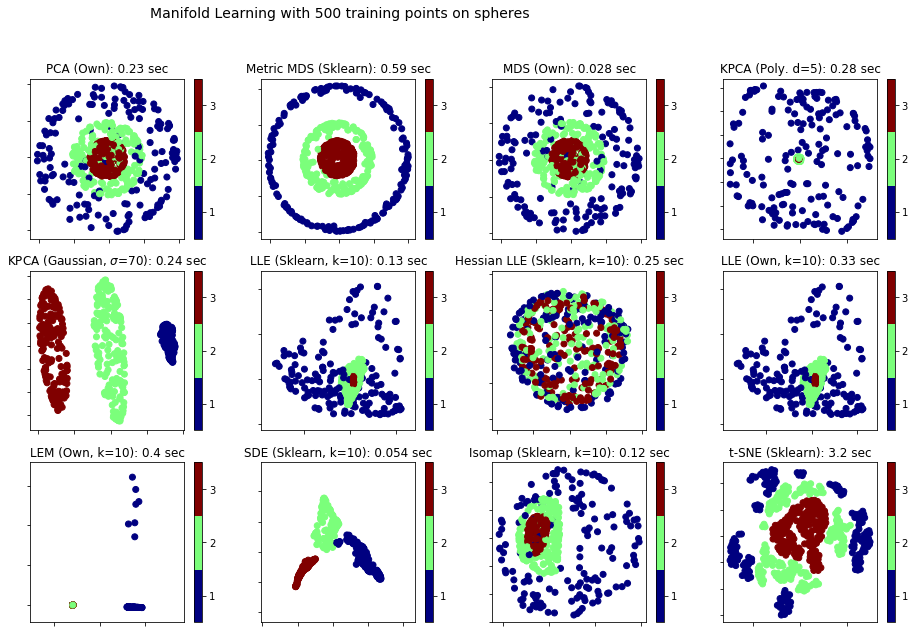


Testing...
PCA (Own): 1.1 sec
KPCA (Poly. d=5): 1.1 sec
KPCA (Gaussian, sigma=70): 5.6 sec
LLE (Sklearn, k=10): 0.089 sec
Hessian LLE (Sklearn, k=10): 0.094 sec
LLE (Own, k=10): 0.24 sec
LEM (Own, k=10): 0.29 sec
Isomap (Sklearn, k=10): 0.038 sec


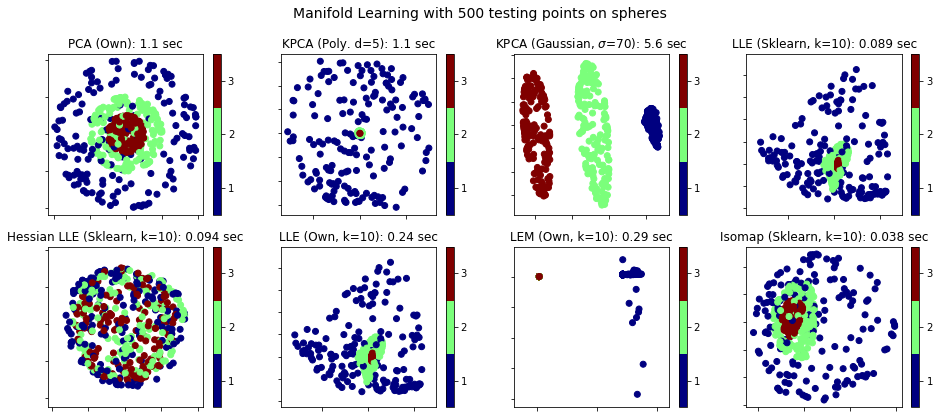

In [162]:
Axes3D

N_points_train, N_points_test = 500, 500

train_set = np.array(synthetic_noise(N_points_train, 200, 100, 50, 0, False))
test_set = np.array(synthetic_noise(N_points_test, 200, 100, 50, 0, False))

titles = ["Manifold Learning with %i training points on spheres" % (N_points_train),
          "Manifold Learning with %i testing points on spheres" % (N_points_test)]

params = {'kpca-poly': {'d': 5},
          'kpca-gaussian': {'sigma': 70},
          'LLE': {'k': 10},
          'LEM': {'k': 10, 'gamma': 50},
          'ISO': {'k': 10},
          'SDE': {'k': 10}
         }

def comparison_class(train, test, n_components, params, titles, testing=False):    
    X_train, y_train = train[:, :-1], train[:, -1]
    if testing:
        X_test, y_test = test[:, :-1], test[:, -1]
    fig = plt.figure(figsize=(20, 10))
    plt.suptitle(titles[0], fontsize=14)

    print('Training...')
    method = polynomial
    KPCA1 = kernelPCA(method, {'d': 1}, n_components, verbose=False)
    t0 = time()
    Y = KPCA1.fit_transform(train)
    t1 = time()
    print("PCA (Own): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(352)
    plot_results(Y, title='PCA (Own): %.2g sec' % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    MDS1 = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = MDS1.fit_transform(train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("Metric MDS (Sklearn): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(353)
    plot_results(Y, title="Metric MDS (Sklearn): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    MDS2 = MDS(p=n_components)
    Y = MDS2.fit_transform(X_train, y_train)
    t1 = time()
    ax = fig.add_subplot(354)
    plot_results(Y, title="MDS (Own): %.2g sec" % (t1 - t0))
    print("MDS (Own): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    method = polynomial
    d = params['kpca-poly']['d']
    KPCA2 = kernelPCA(method, {'d': d}, n_components, verbose=False)
    t0 = time()
    Y = KPCA2.fit_transform(train)
    t1 = time()
    print("KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
    ax = fig.add_subplot(355)
    plot_results(Y, title="KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    method = gaussian
    sigma = params['kpca-gaussian']['sigma']
    KPCA3 = kernelPCA(method, {'sigma': sigma}, n_components, verbose=False)
    t0 = time()
    Y = KPCA3.fit_transform(train)
    t1 = time()
    print(r"KPCA (Gaussian, sigma=%.2g): %.2g sec" % (sigma, t1 - t0))
    ax = fig.add_subplot(357)
    plot_results(Y, title=r"KPCA (Gaussian, $\sigma$=%.2g): %.2g sec" % (sigma, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    n_neighbors = params['LLE']['k']
    methods = ['standard', 'hessian']
    labels = ['LLE (Sklearn, k=%.2g)' % n_neighbors, 'Hessian LLE (Sklearn, k=%.2g)' % n_neighbors]

    for i, method in enumerate(methods):
        t0 = time()
        LLE_ = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                              eigen_solver='dense',
                                              method=method)
        if i==1:
            LLE1 = LLE_
            Y = LLE1.fit_transform(X_train)
        else:
            LLE2 = LLE_
            Y = LLE2.fit_transform(X_train)
        Y = pd.DataFrame(Y)
        Y['Y'] = y_train
        t1 = time()
        print("%s: %.2g sec" % (labels[i], t1 - t0))
        ax = fig.add_subplot(3, 5, 8+i)
        plot_results(Y, title="%s: %.2g sec" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    n_neighbors = params['LLE']['k']
    LLE3 = LLE(k=n_neighbors, p=n_components, reg=1e-3, verbose=False)
    t0 = time()
    Y = LLE3.fit_transform(X_train, y_train)
    t1= time()
    print("LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 10)
    plot_results(Y, title="LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
    n_neighbors = params['LEM']['k']
    gamma = params['LEM']['gamma']
    LEM1=LEM(k=n_neighbors, p=n_components, gamma=gamma, reg=1e-3, verbose=False)
    t0 = time()
    Y = LEM1.fit_transform(X_train, y_train)
    t1 = time()
    print("LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 12)
    plot_results(Y, title="LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    n_neighbors = params['SDE']['k']
    LEM2 = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    Y = LEM2.fit_transform(X_train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("SDE (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 13)
    plot_results(Y, title="SDE (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    n_neighbors = params['ISO']['k']
    ISO = manifold.Isomap(n_neighbors, n_components)
    Y = ISO.fit_transform(X_train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 14)
    plot_results(Y, title="Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    TSNE = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
    Y = TSNE.fit_transform(X_train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("t-SNE (Sklearn): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(3, 5, 15)
    plot_results(Y, title="t-SNE (Sklearn): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()
    
    if testing:
        fig = plt.figure(figsize=(16, 6.5))
        plt.suptitle(titles[1], fontsize=14)
        print()
        print('Testing...')
        t0 = time()
        Y = KPCA1.transform(test)
        t1 = time()
        print("PCA (Own): %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(241)
        plot_results(Y, title='PCA (Own): %.2g sec' % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = KPCA2.transform(test)
        t1 = time()
        print("KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
        ax = fig.add_subplot(242)
        plot_results(Y, title="KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = KPCA3.transform(test)
        t1 = time()
        print(r"KPCA (Gaussian, sigma=%.2g): %.2g sec" % (sigma, t1 - t0))
        ax = fig.add_subplot(243)
        plot_results(Y, title=r"KPCA (Gaussian, $\sigma$=%.2g): %.2g sec" % (sigma, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        n_neighbors = params['LLE']['k']
        methods = ['standard', 'hessian']
        labels = ['LLE (Sklearn, k=%.2g)' % n_neighbors, 'Hessian LLE (Sklearn, k=%.2g)' % n_neighbors]

        for i, method in enumerate(methods):
            t0 = time()
            if i==1:
                LLE_ = LLE1
                Y = LLE1.transform(X_test)
            else:
                LLE_ = LLE2
                Y = LLE2.transform(X_test)
            t1 = time()
            Y = pd.DataFrame(Y)
            Y['Y'] = y_test
            print("%s: %.2g sec" % (labels[i], t1 - t0))
            ax = fig.add_subplot(2, 4, 4+i)
            plot_results(Y, title="%s: %.2g sec" % (labels[i], t1 - t0))
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())
            plt.axis('tight')

        t0 = time()
        Y = LLE3.transform(X_test, y_test)
        t1= time()
        print("LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax = fig.add_subplot(246)
        plot_results(Y, title="LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = LEM1.fit_transform(X_test, y_test)
        t1 = time()
        print("LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax = fig.add_subplot(247)
        plot_results(Y, title="LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = ISO.transform(X_test)
        t1 = time()
        Y = pd.DataFrame(Y)
        Y['Y'] = y_test
        print("Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax = fig.add_subplot(248)
        plot_results(Y, title="Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
    
comparison_class(train_set, test_set, 2, params, titles, True)

<a id='Kernel PCA: influence of sigma'></a>

### Kernel PCA: influence of sigma

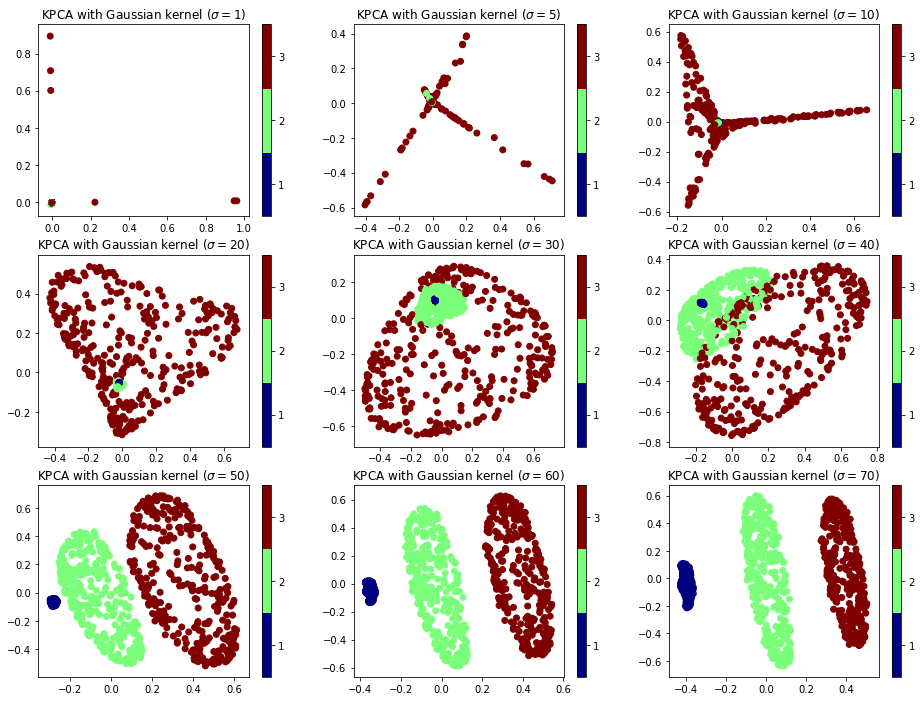

In [1113]:
plt.figure(figsize=(16, 12))
method = gaussian
for i, sigma in enumerate([1, 5, 10, 20, 30, 40, 50, 60, 70]):
    kpca = kernelPCA(method, {'sigma': sigma}, 2, verbose=False)
    train_new = kpca.fit_transform(data)
    plt.subplot(3, 3, i+1)
    plot_results(train_new, title=r'KPCA with Gaussian kernel ($\sigma={:3.0f}$)'.format(sigma))
plt.subplots_adjust()
plt.show()

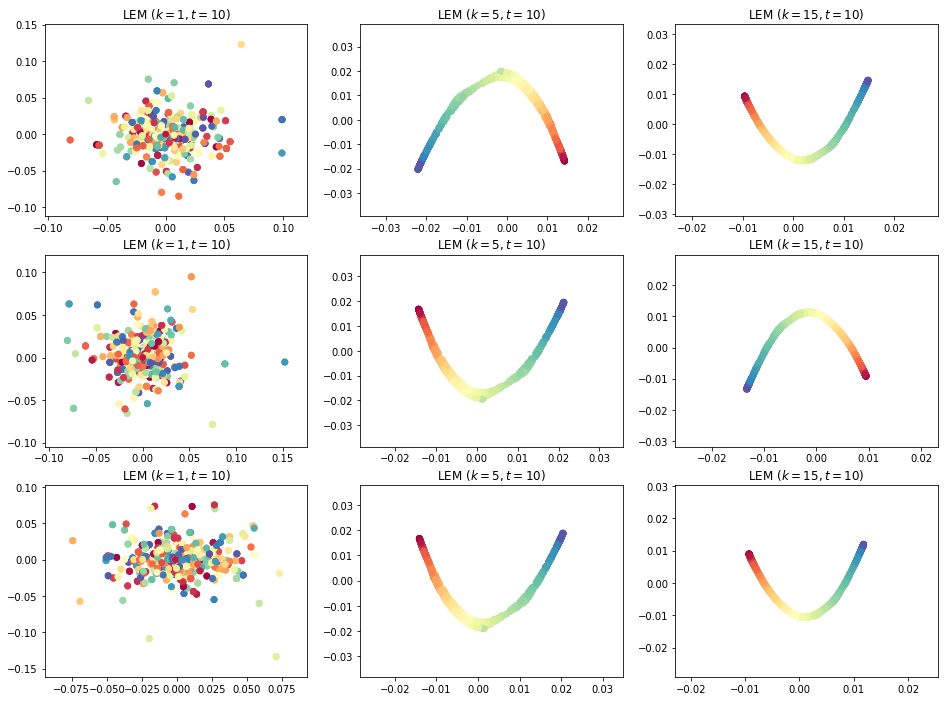

In [1269]:
data, color = datasets.samples_generator.make_swiss_roll(1000, noise=0)
plt.figure(figsize=(16, 12))
method = gaussian
for i, (k, t) in enumerate(zip([1, 5, 15, 1, 5, 15, 1, 5, 15], [5, 5, 5, 10, 10, 10, 1e3, 1e3, 1e3])):
    L=LEM(k=k, p=2, gamma=t, verbose=False)
    train_new = L.fit_transform(data, data[:, -1], reg=1e-3)
    plt.subplot(3, 3, i+1)
    plot_results(train_new, title='LEM ($k={:3.0f}, t={:3.0f}$)'.format(k, gamma), color=color)
plt.subplots_adjust()
plt.show()

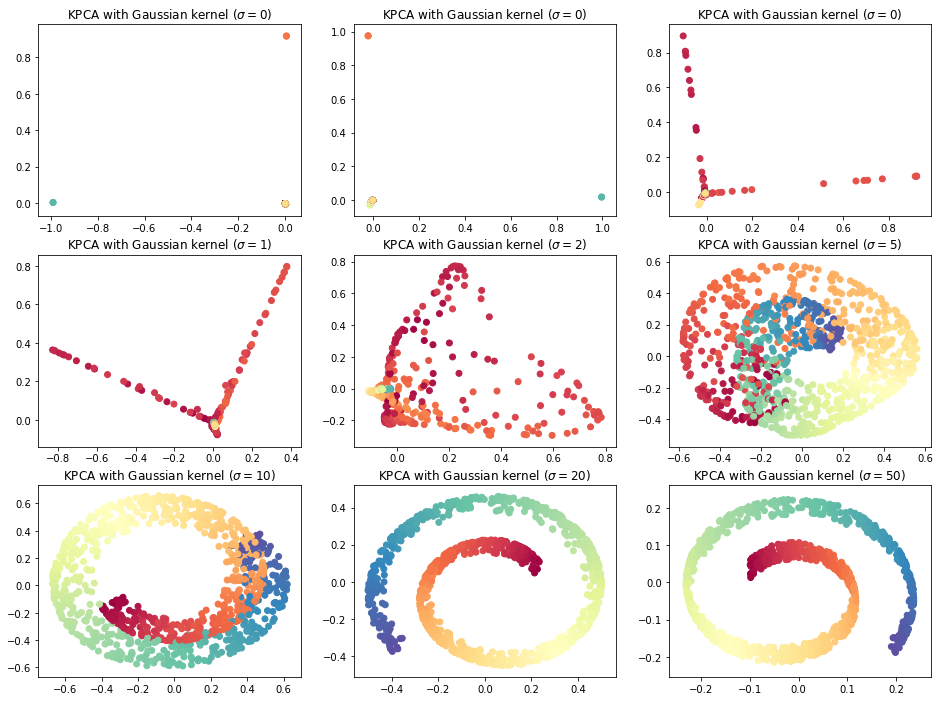

In [1121]:
plt.figure(figsize=(16, 12))
method = gaussian
for i, sigma in enumerate([0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 50]):
    kpca = kernelPCA(method, {'sigma': sigma}, 2, verbose=False)
    train_new = kpca.fit_transform(data)
    plt.subplot(3, 3, i+1)
    plot_results(train_new, title=r'KPCA with Gaussian kernel ($\sigma={:3.0f}$)'.format(sigma), color=color)
plt.subplots_adjust()
plt.show()

Comparison with scikit learn

PCA (Own): 0.71 sec
Metric MDS (Sklearn): 3.5 sec
MDS (Own): 3.5 sec
KPCA (Poly. d=5): 0.85 sec
KPCA (Gaussian, sigma=10): 0.88 sec
LLE (Sklearn, k=10): 0.21 sec
Hessian LLE (Sklearn, k=10): 0.53 sec
LLE (Own, k=10): 1.1 sec
LEM (Own, k=10): 0.95 sec
LEM (Sklearn, k=10): 0.1 sec
Isomap (Sklearn, k=10): 0.51 sec
t-SNE (Sklearn): 9.4 sec


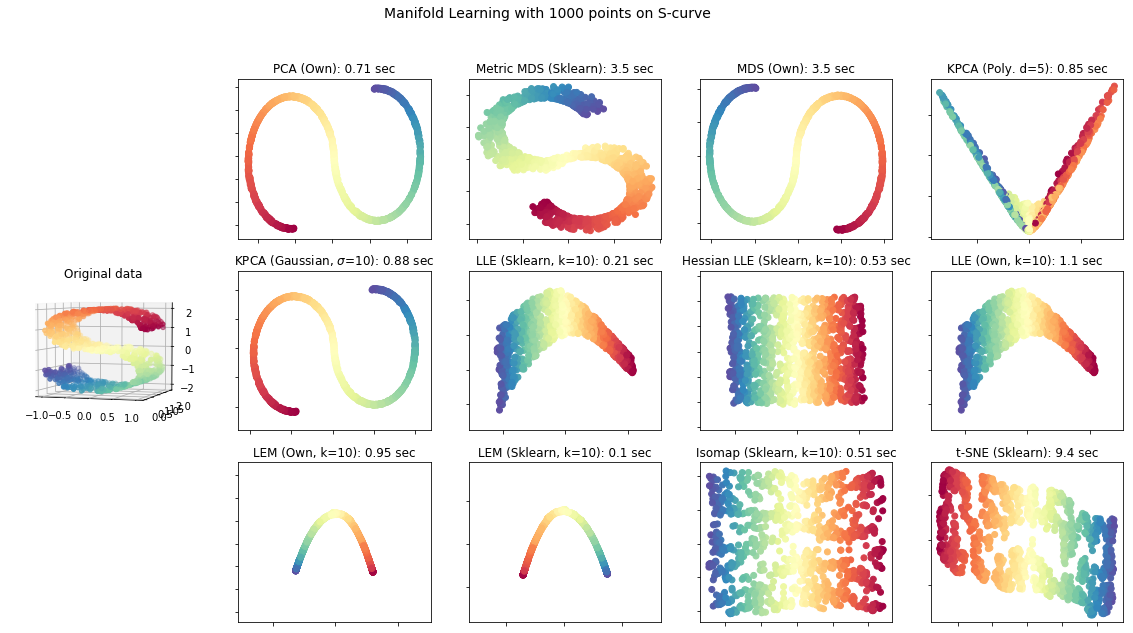

In [1640]:
# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
data = datasets.samples_generator.make_s_curve(n_points, random_state=0)
title = "Manifold Learning with %i points on S-curve" % (n_points)
params = {'kpca-poly': {'d': 5},
          'kpca-gaussian': {'sigma': 10},
          'LLE': {'k': 10},
          'LEM': {'k': 10, 'gamma': 10},
          'ISO': {'k': 10},
          'SDE': {'k': 10}
         }

def comparison(data, n_components, params, title):
    X, color= data
    fig = plt.figure(figsize=(20, 10))
    plt.suptitle(title, fontsize=14)

    ax = fig.add_subplot(356, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    plt.title('Original data')
    ax.view_init(4, -72)

    method = polynomial
    kpca = kernelPCA(method, {'d': 1}, n_components, verbose=False)
    t0 = time()
    Y = kpca.fit_transform(X)
    t1 = time()
    print("PCA (Own): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(352)
    plot_results(Y, title='PCA (Own): %.2g sec' % (t1 - t0), color=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(X)
    t1 = time()
    print("Metric MDS (Sklearn): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(353)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("Metric MDS (Sklearn): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    mds_ = MDS(p=n_components)
    Y = mds_.fit_transform(X, None)
    ax = fig.add_subplot(354)
    plot_results(Y, title="MDS (Own): %.2g sec" % (t1 - t0), color=color)
    print("MDS (Own): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    method = polynomial
    d = params['kpca-poly']['d']
    kpca = kernelPCA(method, {'d': d}, n_components, verbose=False)
    t0 = time()
    Y = kpca.fit_transform(X)
    t1 = time()
    print("KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
    ax = fig.add_subplot(355)
    plot_results(Y, title="KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0), color=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    method = gaussian
    sigma = params['kpca-gaussian']['sigma']
    kpca = kernelPCA(method, {'sigma': 10}, n_components, verbose=False)
    t0 = time()
    Y = kpca.fit_transform(X)
    t1 = time()
    print(r"KPCA (Gaussian, sigma=%.2g): %.2g sec" % (sigma, t1 - t0))
    ax = fig.add_subplot(357)
    plot_results(Y, title=r"KPCA (Gaussian, $\sigma$=%.2g): %.2g sec" % (sigma, t1 - t0), color=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    n_neighbors = params['LLE']['k']
    methods = ['standard', 'hessian']
    labels = ['LLE (Sklearn, k=%.2g)' % n_neighbors, 'Hessian LLE (Sklearn, k=%.2g)' % n_neighbors]

    for i, method in enumerate(methods):
        t0 = time()
        Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                            eigen_solver='auto',
                                            method=method).fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (labels[i], t1 - t0))

        ax = fig.add_subplot(3, 5, 8+i)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("%s: %.2g sec" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    n_neighbors = params['LLE']['k']
    L=LLE(k=n_neighbors, p=2, verbose=False)
    t0 = time()
    Y = L.fit_transform(X, None, reg=1e-3)
    t1= time()
    print("LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 10)
    plot_results(Y, title="LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0), color=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
    n_neighbors = params['LEM']['k']
    gamma = params['LEM']['gamma']
    L=LEM(k=n_neighbors, p=2, gamma=gamma, verbose=False)
    t0 = time()
    Y = L.fit_transform(X, None, reg=1e-8)
    t1 = time()
    print("LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 12)
    plot_results(Y, title="LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0), color=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    n_neighbors = params['SDE']['k']
    se = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    Y = se.fit_transform(X)
    t1 = time()
    print("LEM (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 13)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("LEM (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    

    t0 = time()
    n_neighbors = params['ISO']['k']
    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
    t1 = time()
    print("Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 14)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE (Sklearn): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(3, 5, 15)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("t-SNE (Sklearn): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()
    
comparison(data=data, n_components=2, params=params, title=title)

PCA (Own): 0.71 sec
Metric MDS (Sklearn): 2.9 sec
MDS (Own): 2.9 sec
KPCA (Poly. d=5): 0.73 sec
KPCA (Gaussian, sigma=10): 0.72 sec
LLE (Sklearn, k=10): 0.21 sec
Hessian LLE (Sklearn, k=10): 0.49 sec
LLE (Own, k=10): 0.84 sec
LEM (Own, k=10): 0.85 sec
LEM (Sklearn, k=10): 0.11 sec
Isomap (Sklearn, k=10): 0.42 sec
t-SNE (Sklearn): 6.8 sec


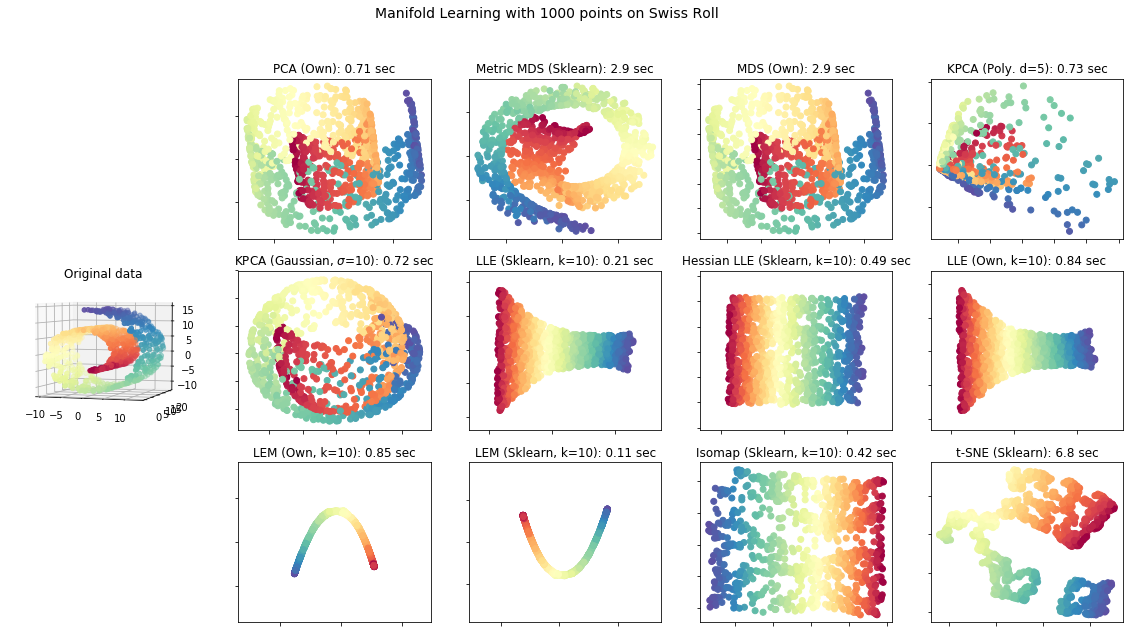

In [1637]:
n_points = 1000
data = datasets.samples_generator.make_swiss_roll(n_points, random_state=0)
title = "Manifold Learning with %i points on Swiss Roll" % (n_points)
params = {'kpca-poly': {'d': 5},
          'kpca-gaussian': {'sigma': 10},
          'LLE': {'k': 10},
          'LEM': {'k': 10, 'gamma': 10},
          'ISO': {'k': 10},
          'SDE': {'k': 10}
         }
comparison(data=data, n_components=2, params=params, title=title)

Load MNIST dataset

In [11]:
path = '/Users/bfiliot/Desktop/ENSAE/3A/STATS_AV/'

def format(X):
    d = pd.DataFrame(X[0])
    d.columns = ['V'+str(i+1) for i in range(d.shape[1])]
    d['Y'] = X[1]
    return d

def load_data(path):
    zip_ref = zipfile.ZipFile(os.path.join(path, 'Data/mnist.pkl.gz'), 'r')
    zip_ref.extractall(os.path.join(path, 'Data'))
    zip_ref.close()
    train, valid, test = pickle.load(open(os.path.join(path, 'Data/mnist.pkl'), 'rb'), encoding='latin1')
    train, valid, test = format(train), format(valid), format(test) 
    return train, valid, test

train, valid, test = load_data(path)

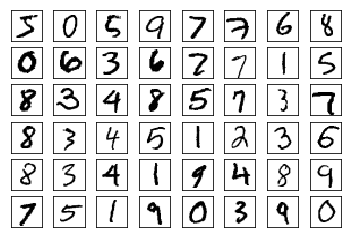

In [12]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(np.array(train.iloc[1000 * i, :-1]).reshape(28, 28), cmap='gray_r')

Training...
PCA (Own): 3.2e+02 sec
Metric MDS (Sklearn): 4.2e+02 sec
MDS (Own): 1.8e+02 sec
KPCA (Poly. d=5): 3.2e+02 sec
KPCA (Gaussian, sigma=50): 3.2e+02 sec
LLE (Sklearn, k=30): 2.7e+02 sec
Hessian LLE (Sklearn, k=30): 2.5e+02 sec
LLE (Own, k=30): 3.5e+02 sec
LEM (Own, k=30): 5.7e+02 sec
LEM (Sklearn, k=30): 1.6e+02 sec
Isomap (Sklearn, k=30): 2.3e+02 sec
t-SNE (Sklearn): 2.3e+02 sec


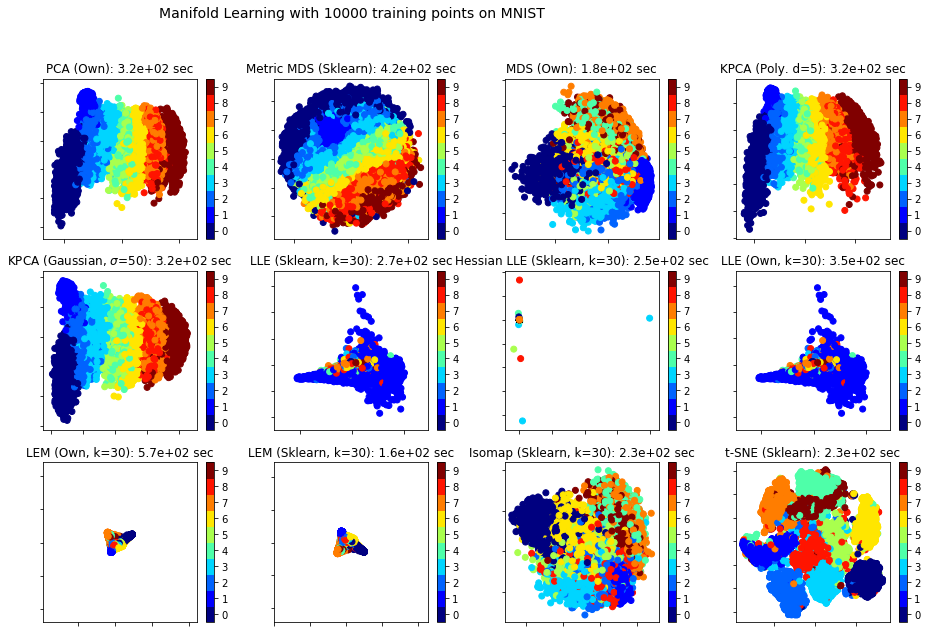


Testing...
PCA (Own): 4.8e+02 sec
KPCA (Poly. d=5): 4.8e+02 sec
KPCA (Gaussian, sigma=50): 9.4e+02 sec
LLE (Sklearn, k=30): 26 sec
Hessian LLE (Sklearn, k=30): 26 sec
LLE (Own, k=30): 20 sec
LEM (Own, k=30): 13 sec
Isomap (Sklearn, k=30): 28 sec


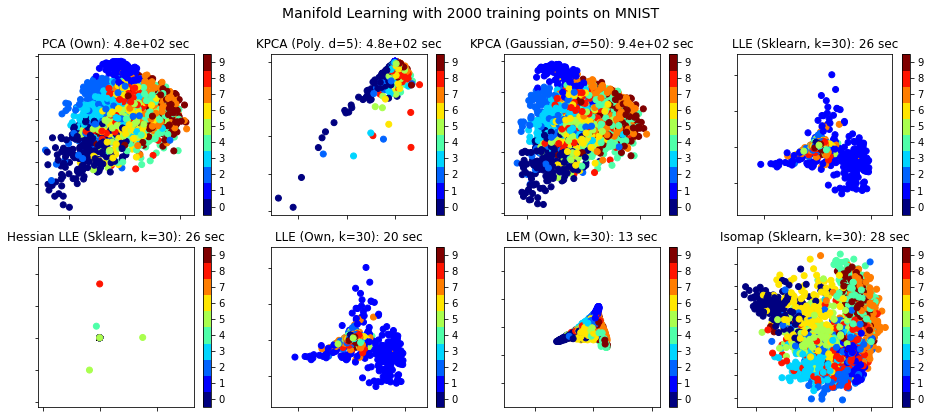

In [13]:
Axes3D

N_train, N_test = 10000, 2000
train_set = np.array(train[:N_train])
test_set = np.array(test[:N_test])
titles = ["Manifold Learning with %i training points on MNIST" % (N_train),
          "Manifold Learning with %i testing points on MNIST" % (N_test)]

params = {'kpca-poly': {'d': 5},
          'kpca-gaussian': {'sigma': 50},
          'LLE': {'k': 30},
          'LEM': {'k': 30, 'gamma': 50},
          'ISO': {'k': 30},
          'SDE': {'k': 30}
         }

def comparison_MNIST(train, test, n_components, params, titles, testing=False):    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test = test[:, :-1], test[:, -1]
    fig = plt.figure(figsize=(20, 10))
    plt.suptitle(titles[0], fontsize=14)

    print('Training...')
    method = polynomial
    KPCA1 = kernelPCA(method, {'d': 1}, n_components, verbose=False)
    t0 = time()
    Y = KPCA1.fit_transform(train)
    t1 = time()
    print("PCA (Own): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(352)
    plot_results(Y, title='PCA (Own): %.2g sec' % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    MDS1 = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = MDS1.fit_transform(train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("Metric MDS (Sklearn): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(353)
    plot_results(Y, title="Metric MDS (Sklearn): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    MDS2 = MDS(p=n_components)
    Y = MDS2.fit_transform(X_train, y_train)
    t1 = time()
    ax = fig.add_subplot(354)
    plot_results(Y, title="MDS (Own): %.2g sec" % (t1 - t0))
    print("MDS (Own): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    method = polynomial
    d = params['kpca-poly']['d']
    KPCA2 = kernelPCA(method, {'d': d}, n_components, verbose=False)
    t0 = time()
    Y = KPCA2.fit_transform(train)
    t1 = time()
    print("KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
    ax = fig.add_subplot(355)
    plot_results(Y, title="KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    method = gaussian
    sigma = params['kpca-gaussian']['sigma']
    KPCA3 = kernelPCA(method, {'sigma': 10}, n_components, verbose=False)
    t0 = time()
    Y = KPCA3.fit_transform(train)
    t1 = time()
    print(r"KPCA (Gaussian, sigma=%.2g): %.2g sec" % (sigma, t1 - t0))
    ax = fig.add_subplot(357)
    plot_results(Y, title=r"KPCA (Gaussian, $\sigma$=%.2g): %.2g sec" % (sigma, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    n_neighbors = params['LLE']['k']
    methods = ['standard', 'hessian']
    labels = ['LLE (Sklearn, k=%.2g)' % n_neighbors, 'Hessian LLE (Sklearn, k=%.2g)' % n_neighbors]

    for i, method in enumerate(methods):
        t0 = time()
        LLE_ = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                              eigen_solver='dense',
                                              method=method)
        if i==1:
            LLE1 = LLE_
            Y = LLE1.fit_transform(X_train)
        else:
            LLE2 = LLE_
            Y = LLE2.fit_transform(X_train)
        Y = pd.DataFrame(Y)
        Y['Y'] = y_train
        t1 = time()
        print("%s: %.2g sec" % (labels[i], t1 - t0))
        ax = fig.add_subplot(3, 5, 8+i)
        plot_results(Y, title="%s: %.2g sec" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    n_neighbors = params['LLE']['k']
    LLE3 = LLE(k=n_neighbors, p=n_components, reg=1e-3, verbose=False)
    t0 = time()
    Y = LLE3.fit_transform(X_train, y_train)
    t1= time()
    print("LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 10)
    plot_results(Y, title="LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
    n_neighbors = params['LEM']['k']
    gamma = params['LEM']['gamma']
    LEM1=LEM(k=n_neighbors, p=n_components, gamma=gamma, reg=1e-3, verbose=False)
    t0 = time()
    Y = LEM1.fit_transform(X_train, y_train)
    #Y.iloc[:, :1] = -Y.iloc[:, :1]
    t1 = time()
    print("LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 12)
    plot_results(Y, title="LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    n_neighbors = params['SDE']['k']
    LEM2 = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    Y = LEM2.fit_transform(X_train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("LEM (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 13)
    plot_results(Y, title="LEM (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    n_neighbors = params['ISO']['k']
    ISO = manifold.Isomap(n_neighbors, n_components)
    Y = ISO.fit_transform(X_train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 14)
    plot_results(Y, title="Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    TSNE = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
    Y = TSNE.fit_transform(X_train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("t-SNE (Sklearn): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(3, 5, 15)
    plot_results(Y, title="t-SNE (Sklearn): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()
    
    if testing:
        fig = plt.figure(figsize=(16, 6.5))
        plt.suptitle(titles[1], fontsize=14)
        print()
        print('Testing...')
        t0 = time()
        Y = KPCA1.transform(test)
        t1 = time()
        print("PCA (Own): %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(241)
        plot_results(Y, title='PCA (Own): %.2g sec' % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = KPCA2.transform(test)
        t1 = time()
        print("KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
        ax = fig.add_subplot(242)
        plot_results(Y, title="KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = KPCA3.transform(test)
        t1 = time()
        print(r"KPCA (Gaussian, sigma=%.2g): %.2g sec" % (sigma, t1 - t0))
        ax = fig.add_subplot(243)
        plot_results(Y, title=r"KPCA (Gaussian, $\sigma$=%.2g): %.2g sec" % (sigma, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        n_neighbors = params['LLE']['k']
        methods = ['standard', 'hessian']
        labels = ['LLE (Sklearn, k=%.2g)' % n_neighbors, 'Hessian LLE (Sklearn, k=%.2g)' % n_neighbors]

        for i, method in enumerate(methods):
            t0 = time()
            if i==1:
                LLE_ = LLE1
                Y = LLE1.transform(X_test)
            else:
                LLE_ = LLE2
                Y = LLE2.transform(X_test)
            t1 = time()
            Y = pd.DataFrame(Y)
            Y['Y'] = y_test
            print("%s: %.2g sec" % (labels[i], t1 - t0))
            ax = fig.add_subplot(2, 4, 4+i)
            plot_results(Y, title="%s: %.2g sec" % (labels[i], t1 - t0))
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())
            plt.axis('tight')

        t0 = time()
        Y = LLE3.transform(X_test, y_test)
        t1= time()
        print("LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax = fig.add_subplot(246)
        plot_results(Y, title="LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = LEM1.fit_transform(X_test, y_test)
        #Y.iloc[:, :1] = -Y.iloc[:, :1]
        t1 = time()
        print("LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax = fig.add_subplot(247)
        plot_results(Y, title="LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = ISO.transform(X_test)
        t1 = time()
        Y = pd.DataFrame(Y)
        Y['Y'] = y_test
        print("Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax = fig.add_subplot(248)
        plot_results(Y, title="Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
    
comparison_MNIST(train_set, test_set, 2, params, titles, True)

In [1421]:
def plot_components(number, proj, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Done.


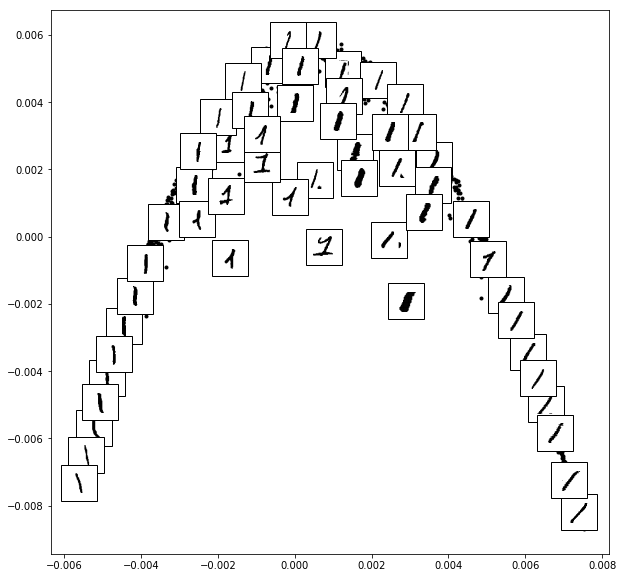

In [1475]:
# Choose 1/4 of the "1" digits to project
data = np.array(train[train.Y == 1][::4])
#L=LLE(k=30, p=2, verbose=True)
L = LEM(k=30, p=2, gamma=50)
train_new = L.fit_transform(data[:, :-1], data[:, -1], reg=1e-3)
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data, np.array(train_new)[:, :-1], images=data[:, :-1].reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

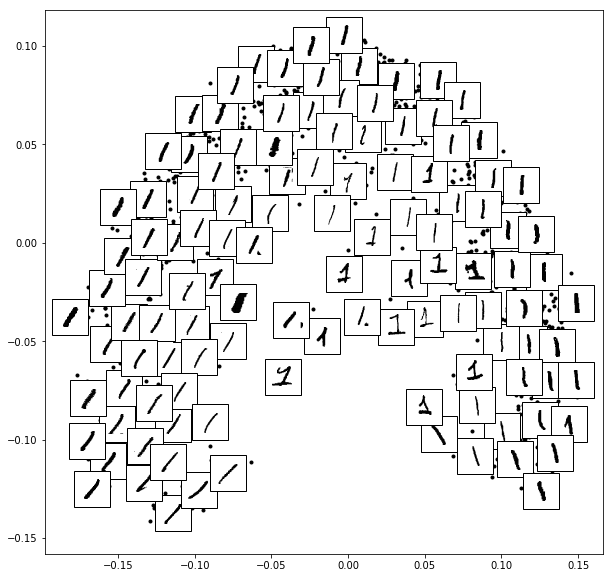

In [1474]:
# Choose 1/4 of the "1" digits to project
data = np.array(train[train.Y == 1][::4])
method = polynomial
d = 1
kpca = kernelPCA(method, {'d': d}, 2, verbose=False)
train_new = kpca.fit_transform(data)
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data, np.array(train_new)[:, :-1], images=data[:, :-1].reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')